In [55]:
import numpy as np
import pandas as pd
import zarr
import xarray as xr
import matplotlib.pyplot as plt
import lightning.pytorch as pl
from omegaconf import OmegaConf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
from lightning.pytorch.callbacks import ModelCheckpoint, Callback
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from main import ClimateEmulationDataModule, ClimateEmulationModule
from _climate_kaggle_metric import score as kaggle_score

from src.models import SimpleCNN
from src.utils import convert_predictions_to_kaggle_format

from temporal_data_module import TemporalDataModule

In [56]:
data_path = 'data/processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr'
data = xr.open_zarr(data_path)

### Plotting

In [57]:
def plot_batch_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))

    plt.plot(train_losses, label="Train Loss (per batch)", linewidth=0.8, alpha=0.8)
    plt.plot(val_losses, label="Validation Loss (per batch)", linewidth=0.8, alpha=0.8)

    plt.xlabel("Batch (time)")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Time")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_epoch_losses(train_epoch_losses, val_epoch_losses):
    epochs = range(1, len(train_epoch_losses) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_epoch_losses, label='Train Loss (per epoch)', marker='o')
    plt.plot(epochs, val_epoch_losses, label='Validation Loss (per epoch)', marker='s')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss per Epoch")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_top_mse_grid_points(y_pred_np, y_true_np, lat_coords, lon_coords, var_names, top_k=3):
    T, C, H, W = y_true_np.shape
    squared_error = (y_pred_np - y_true_np) ** 2

    top_coords = []

    for c in range(C):
        var = var_names[int(c)]
        var_error = squared_error[:, c, :, :]
        flat_error = var_error.reshape(-1)
        top_k_idx = np.argpartition(flat_error, -top_k)[-top_k:]
        top_k_idx = top_k_idx[np.argsort(flat_error[top_k_idx])[::-1]]

        for idx in top_k_idx:
            t, h, w = np.unravel_index(idx, (T, H, W))
            top_coords.append({
                "var": var,
                "t": int(t),
                "h": int(h),
                "w": int(w),
                "mse": var_error[t, h, w].item()
            })

    plt.figure(figsize=(10, 6))
    plt.imshow(np.zeros((H, W)), cmap='Greys', alpha=0.1)

    color_map = {var: color for var, color in zip(var_names, ['red', 'blue', 'green', 'orange'])}

    for entry in top_coords:
        plt.scatter(entry["w"], entry["h"], color=color_map[entry["var"]],
                    s=100, edgecolors='black')

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=var,
               markerfacecolor=color_map[var], markersize=10, markeredgecolor='black')
        for var in var_names
    ]
    plt.legend(handles=legend_elements)
    plt.title(f"Top {top_k} Highest MSE Grid Locations per Output Variable")
    plt.xlabel("Longitude Index (W)")
    plt.ylabel("Latitude Index (H)")
    plt.xlim(0, W - 1)
    plt.ylim(H - 1, 0)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Model

In [61]:
class ConvBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout3d(dropout),

            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout3d(dropout),
        )

    def forward(self, x):
        return self.block(x)

class ClimateUNet3D(nn.Module):
    def __init__(self, in_channels=5, out_channels=2, base_channels=32, dropout=0.1):
        super().__init__()

        # Encoder
        self.enc1 = ConvBlock3D(in_channels, base_channels, dropout)
        self.pool1 = nn.MaxPool3d((1, 2, 2))

        self.enc2 = ConvBlock3D(base_channels, base_channels * 2, dropout)
        self.pool2 = nn.MaxPool3d((1, 2, 2))

        self.enc3 = ConvBlock3D(base_channels * 2, base_channels * 4, dropout)
        self.pool3 = nn.MaxPool3d((1, 2, 2))

        # Bottleneck
        self.bottleneck = ConvBlock3D(base_channels * 4, base_channels * 8, dropout)

        # Decoder
        self.up3 = nn.ConvTranspose3d(base_channels * 8, base_channels * 4, kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.dec3 = ConvBlock3D(base_channels * 8, base_channels * 4, dropout)

        self.up2 = nn.ConvTranspose3d(base_channels * 4, base_channels * 2, kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.dec2 = ConvBlock3D(base_channels * 4, base_channels * 2, dropout)

        self.up1 = nn.ConvTranspose3d(base_channels * 2, base_channels, kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.dec1 = ConvBlock3D(base_channels * 2, base_channels, dropout)

        # Final output
        self.out_conv = nn.Conv3d(base_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4)  # [B, C, t, H, W]

        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        # Bottleneck
        b = self.bottleneck(p3)

        # Decoder
        u3 = self.up3(b)
        u3 = torch.cat([u3, e3], dim=1)
        d3 = self.dec3(u3)

        u2 = self.up2(d3)
        u2 = torch.cat([u2, e2], dim=1)
        d2 = self.dec2(u2)

        u1 = self.up1(d2)
        u1 = torch.cat([u1, e1], dim=1)
        d1 = self.dec1(u1)

        out = self.out_conv(d1)
        out = out[:, :, -1]
        
        return out


In [62]:
class TrainingMetrics(Callback):
    def __init__(self):
        self.train_epoch_losses = []
        self.val_epoch_losses = []

        self._train_losses = []
        self._val_losses = []

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        loss = outputs['loss'] if isinstance(outputs, dict) else outputs
        self._train_losses.append(loss.item())

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx=0):
        loss = outputs['loss'] if isinstance(outputs, dict) else outputs
        self._val_losses.append(loss.item())

    def on_train_epoch_end(self, trainer, pl_module):
        if self._train_losses:
            avg = sum(self._train_losses) / len(self._train_losses)
            self.train_epoch_losses.append(avg)
            self._train_losses.clear()

    def on_validation_epoch_end(self, trainer, pl_module):
        if self._val_losses:
            avg = sum(self._val_losses) / len(self._val_losses)
            self.val_epoch_losses.append(avg)
            self._val_losses.clear()


### Training

In [74]:
config = OmegaConf.create({
    "data": {
        "path": data_path,
        # "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"],
        "input_vars": ["CO2", "CH4", "BC", "rsdt"],
        "output_vars": ["tas", "pr"],
        "train_ssps": ["ssp126", "ssp370", "ssp585"],
        "test_ssp": "ssp245",
        "target_member_id": 0,
        "batch_size": 32,
        "num_workers": 39,
        
    }
})

In [ ]:
data_module = TemporalDataModule(**config.data)
data_module.setup()

In [63]:
in_channels = len(config.data['input_vars'])
out_channels = len(config.data['output_vars'])

model = ClimateUNet3D(base_channels=64, in_channels=in_channels, out_channels=out_channels)

lightning_module=ClimateEmulationModule(
    model = model,
    learning_rate = 5e-4
)

In [66]:
logger = TrainingMetrics()

trainer = pl.Trainer(
    max_epochs=20,
    accelerator='auto',
    callbacks=[logger]    
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [67]:
trainer.fit(lightning_module, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type          | Params | Mode 
----------------------------------------------------
0 | model     | ClimateUNet3D | 21.7 M | train
1 | criterion | MSELoss       | 0      | train
----------------------------------------------------
21.7 M    Trainable params
0         Non-trainable params
21.7 M    Total params
86.873    Total estimated model params size (MB)
79        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


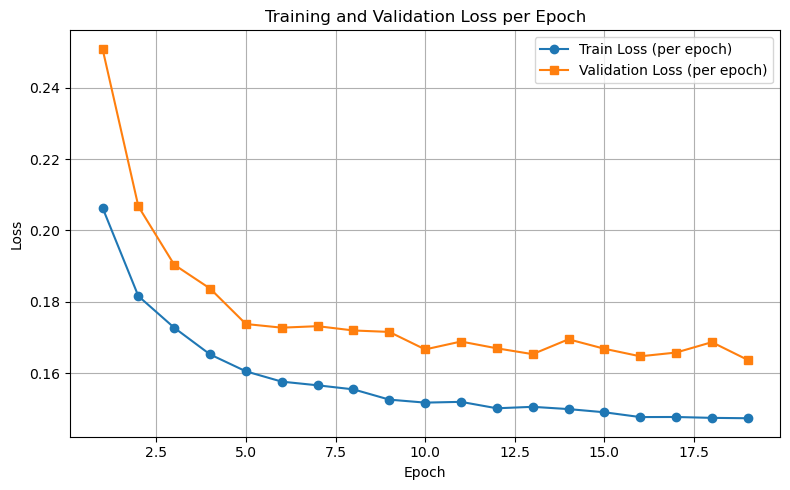

In [68]:
train_losses = logger.train_epoch_losses
val_losses = logger.val_epoch_losses
min_len = min(len(train_losses), len(val_losses))

plot_epoch_losses(train_losses[:min_len], val_losses[:min_len])

In [69]:
trainer.test(lightning_module, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
test/pr/avg/monthly_rmse     4.189457893371582
 test/pr/time_mean_rmse       3.7205650806427
 test/pr/time_stddev_mae    1.3585211038589478
test/tas/avg/monthly_rmse   290.77520751953125
 test/tas/time_mean_rmse    290.73492431640625
test/tas/time_stddev_mae     3.461483955383301
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/tas/avg/monthly_rmse': 290.77520751953125,
  'test/tas/time_mean_rmse': 290.73492431640625,
  'test/tas/time_stddev_mae': 3.461483955383301,
  'test/pr/avg/monthly_rmse': 4.189457893371582,
  'test/pr/time_mean_rmse': 3.7205650806427,
  'test/pr/time_stddev_mae': 1.3585211038589478}]

### Produce Submission

In [70]:
model.eval()
all_preds = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for x, y_true in data_module.test_dataloader():
    x = x.to(device)
    with torch.no_grad():
        y_pred = model(x.to(device)).squeeze(0)
    all_preds.append(y_pred.cpu().numpy())

y_pred_np = np.concatenate(all_preds, axis=0)
y_pred_output = data_module.normalizer.inverse_transform_output(y_pred_np)

lat_coords, lon_coords = data_module.get_coords()
time_coords = np.arange(y_pred_np.shape[0])
var_names = config.data['output_vars']

In [71]:
submission_df = convert_predictions_to_kaggle_format(
    y_pred_output, time_coords, lat_coords, lon_coords, var_names
)

In [72]:
print(submission_df.shape)

(2488320, 2)


In [73]:
submission_df.to_csv("submission.csv", index=False)